<a href="https://colab.research.google.com/github/meryreddoor/yogagame_/blob/primeraRama/Modelos%20v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display 
from PIL import Image
import h5py
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2



Using TensorFlow backend.


In [0]:
data = pd.read_pickle("/content/w_arraydef_sabado.pkl")

In [11]:
data.shape

(678, 4)

In [12]:
data['array']

0      [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1      [[249, 249, 249, 248, 248, 248, 248, 248, 248,...
2      [[143, 139, 131, 128, 129, 127, 129, 133, 137,...
3      [[224, 220, 226, 225, 223, 184, 105, 58, 77, 3...
4      [[204, 205, 205, 203, 205, 204, 204, 206, 202,...
                             ...                        
673    [[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, ...
674    [[56, 88, 107, 108, 91, 59, 56, 13, 0, 0, 8, 3...
675    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
676    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
677    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
Name: array, Length: 678, dtype: object

In [0]:
new_dummies = pd.get_dummies(data['pose'])

In [14]:
data_new = data.join(new_dummies)
data_new.head()

,pose,png,path,array,ardha matsyendrasana,chaturanga dandasana,garudasana,other
0,chaturanga dandasana,33-0.png,../img/chaturanga dandasana/33-0.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,1,0,0
1,chaturanga dandasana,76-0.png,../img/chaturanga dandasana/76-0.png,"[[249, 249, 249, 248, 248, 248, 248, 248, 248,...",0,1,0,0
2,chaturanga dandasana,50-2.png,../img/chaturanga dandasana/50-2.png,"[[143, 139, 131, 128, 129, 127, 129, 133, 137,...",0,1,0,0
3,chaturanga dandasana,9-0.png,../img/chaturanga dandasana/9-0.png,"[[224, 220, 226, 225, 223, 184, 105, 58, 77, 3...",0,1,0,0
4,chaturanga dandasana,92-0.png,../img/chaturanga dandasana/92-0.png,"[[204, 205, 205, 203, 205, 204, 204, 206, 202,...",0,1,0,0


In [15]:
data_new.columns

Index(['pose', 'png', 'path', 'array', 'ardha matsyendrasana',
       'chaturanga dandasana', 'garudasana', 'other'],
      dtype='object')

In [16]:
data_new['gt'] = data_new[['ardha matsyendrasana','chaturanga dandasana','garudasana','other']].apply(lambda x: pd.Series([x.values]), axis=1)
data_new.head()

,pose,png,path,array,ardha matsyendrasana,chaturanga dandasana,garudasana,other,gt
0,chaturanga dandasana,33-0.png,../img/chaturanga dandasana/33-0.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,1,0,0,"[0, 1, 0, 0]"
1,chaturanga dandasana,76-0.png,../img/chaturanga dandasana/76-0.png,"[[249, 249, 249, 248, 248, 248, 248, 248, 248,...",0,1,0,0,"[0, 1, 0, 0]"
2,chaturanga dandasana,50-2.png,../img/chaturanga dandasana/50-2.png,"[[143, 139, 131, 128, 129, 127, 129, 133, 137,...",0,1,0,0,"[0, 1, 0, 0]"
3,chaturanga dandasana,9-0.png,../img/chaturanga dandasana/9-0.png,"[[224, 220, 226, 225, 223, 184, 105, 58, 77, 3...",0,1,0,0,"[0, 1, 0, 0]"
4,chaturanga dandasana,92-0.png,../img/chaturanga dandasana/92-0.png,"[[204, 205, 205, 203, 205, 204, 204, 206, 202,...",0,1,0,0,"[0, 1, 0, 0]"


In [0]:
X = np.stack(data['array'])
X = X / 255.0
y = np.stack(data_new['gt'])

In [18]:
y.shape

(678, 4)

In [19]:
X.shape

(678, 224, 224)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [0]:
img_rows, img_cols = 224, 224

In [0]:
# para poner el canala que falta
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

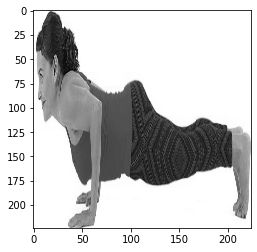

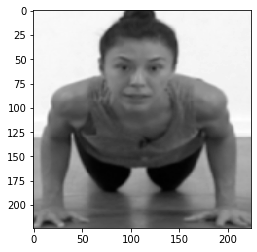

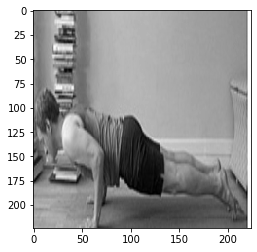

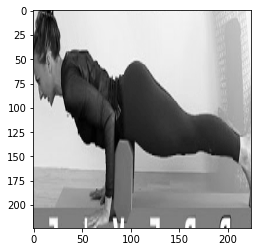

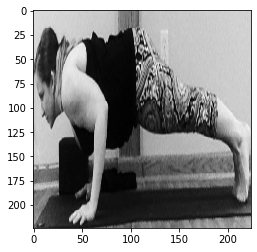

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
columns = 5
for i in range(columns):
    plt.figure()
    im = X[i]
    plt.imshow(im,cmap="gray")

In [0]:
# PRIMER MODELO 
batch_size = 32

classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (224,224, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'softmax')) # number of classes
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Data Augmentation
datagen=ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(dataframe=X_train,
                                            x_col="id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(224,224))

valid_generator=datagen.flow_from_dataframe(dataframe=X,
                                            x_col="id",
                                            y_col="label",
                                            subset="validation",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(224,224))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=y,
                                                x_col="id",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                target_size=(224,224))

'''batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_dataframe('data_new',
                                                 x_col='array',
                                                 y_col='gt',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_dataframe('data_new',
                                            x_col='array',
                                            y_col='gt',
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

classifier.fit_generator(training_set,
                         steps_per_epoch = 729 // batch_size, # number of training set images, 729
                         epochs = 1,
                         validation_data = test_set,
                         validation_steps = 229 // batch_size) # number of test set images, 229
'''
#classifier.fit(X_train,y_train,
#               batch_size = batch_size,
#               epochs = 15,
#               verbose = 1,
#               validation_data = (X_test,y_test))



IndexError: ignored

In [0]:
scores = classifier.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Accuracy: 95.59%
Test loss: 0.6125838309526443
Test accuracy: 0.9558823529411765


In [0]:
classifier.save('my_model_multiclass10.h5') #save model 

In [0]:
print(classifier.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 93312)           

In [0]:
#SEGUNDO MODELO
# Step 1 - Convolution
from keras.layers.normalization import BatchNormalization
modelo = Sequential()
modelo.add(Conv2D(32, (3, 3), input_shape = (224, 224, 1), activation = 'relu'))

# Step 2 - Pooling
modelo.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
modelo.add(Conv2D(32, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2, 2)))
modelo.add(Dropout(0.25))
modelo.add(Conv2D(64, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2, 2)))
modelo.add(Dropout(0.01))
# Step 3 - Flattening
modelo.add(Flatten())

# Step 4 - Full connection
modelo.add(Dense(activation = 'relu', units=128))
modelo.add(Dense(activation = 'relu',units=128))
modelo.add(Dense(activation = 'relu', units=128))
modelo.add(Dense(activation = 'softmax', units=4))

# Compiling the CNN
modelo.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
batch_size = 400
epochs = 35
modelo.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_test, y_test))

modelo.summary()

Train on 806 samples, validate on 90 samples
Epoch 1/35
 - 50s - loss: 1.5729 - acc: 0.3002 - val_loss: 1.9348 - val_acc: 0.3333
Epoch 2/35
 - 47s - loss: 2.6584 - acc: 0.2940 - val_loss: 1.3728 - val_acc: 0.2889
Epoch 3/35
 - 46s - loss: 1.3631 - acc: 0.3275 - val_loss: 1.3800 - val_acc: 0.2889
Epoch 4/35
 - 46s - loss: 1.3854 - acc: 0.3027 - val_loss: 1.3714 - val_acc: 0.2889
Epoch 5/35
 - 49s - loss: 1.3499 - acc: 0.3052 - val_loss: 1.3695 - val_acc: 0.3889
Epoch 6/35
 - 50s - loss: 1.3327 - acc: 0.4293 - val_loss: 1.3689 - val_acc: 0.4667
Epoch 7/35
 - 50s - loss: 1.3392 - acc: 0.4591 - val_loss: 1.3580 - val_acc: 0.4889
Epoch 8/35
 - 46s - loss: 1.3314 - acc: 0.4305 - val_loss: 1.3295 - val_acc: 0.5222
Epoch 9/35
 - 45s - loss: 1.2982 - acc: 0.4541 - val_loss: 1.2464 - val_acc: 0.5222
Epoch 10/35
 - 45s - loss: 1.2128 - acc: 0.4677 - val_loss: 1.1163 - val_acc: 0.6111
Epoch 11/35
 - 45s - loss: 1.0968 - acc: 0.5558 - val_loss: 0.9599 - val_acc: 0.6444
Epoch 12/35
 - 47s - loss: 0.

In [0]:
data_new.columns

NameError: ignored

In [0]:
class_names = ('ardha matsyendrasana','chaturanga dandasana', 'garudasana ', 'other')

[2 2 1 1 3 1 0 3 0 1 2 1 0 0 3 2 0 1 0 3 0 1 3 1 2 1 3 0 1 0 1 3 2 1 2 2 3
 3 0 1 1 2 1 0 3 3 2 3 1 0 0 1 2 0 2 1 3 3 1 1 0 1 0 2 2 2 0 0]
[2 2 1 1 3 1 0 3 0 1 2 1 0 0 3 2 0 1 0 3 0 1 2 1 2 1 3 0 1 0 1 3 2 1 2 2 3
 3 2 1 1 2 1 0 3 3 2 2 1 0 0 1 2 0 2 1 3 3 1 1 0 1 0 2 2 2 0 0]


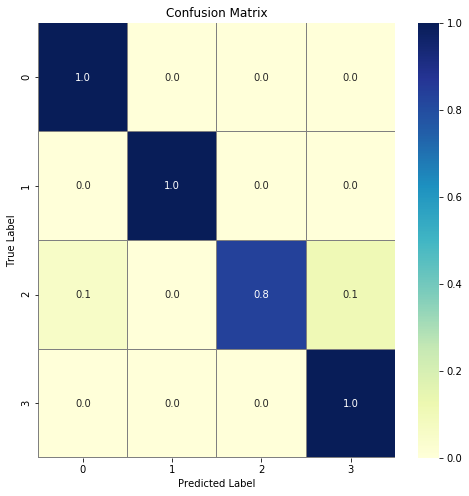

In [0]:
Y_pred = classifier.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

[3.4376320e-05 9.9991834e-01 3.3903627e-06 4.4001081e-05]
(1, 224, 224, 1)
Probs -> ardha matsyendrasana:0.00003 chaturanga dandasana:0.99992 garudasana:0.00000 other:0.00004


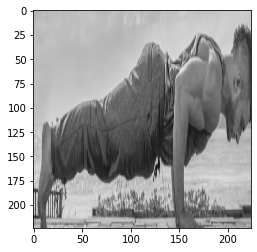

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = X_test[40]
pred = classifier.predict(np.expand_dims(img,axis=0))[0]
print(pred)
print(np.expand_dims(img,axis=0).shape)
plt.imshow(Image.fromarray(img.squeeze()*255))
'','', ' ', 'other'
print("Probs -> ardha matsyendrasana:{0:.5f} chaturanga dandasana:{1:.5f} garudasana:{2:.5f} other:{3:.5f}".format(pred[0],pred[1],pred[2],pred[3]))

In [0]:
import glob

def makeImagDf(path):
    dictionary = {}
    for paths in glob.glob(path):
        dictionary.setdefault('pose', []).append(paths.split('/')[-2])
        dictionary.setdefault('png', []).append(paths.split('/')[-1])
        dictionary.setdefault('path', []).append(paths)
        dictionary.setdefault('array', []).append(cv2.resize(cv2.imread(paths, cv2.IMREAD_GRAYSCALE),(224,224)))
    images = pd.DataFrame(dictionary)
    return images

In [0]:
data_ima = makeImagDf('/content/media_64206_original_100-Ardha Matsyendrasana Half lord of the fishes yoga pose.jpg')

In [0]:
data_ima

,pose,png,path,array
0,content,media_64206_original_100-Ardha Matsyendrasana ...,/content/media_64206_original_100-Ardha Matsye...,"[[247, 247, 247, 247, 247, 247, 247, 247, 247,..."


In [0]:
X = np.stack(data_ima['array'])
X = X / 255.0

NameError: ignored

error: ignored

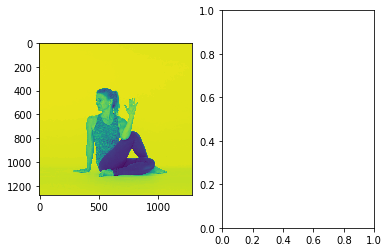

In [8]:
#PIC = X # transform pic
import cv2
import matplotlib.pyplot as plt
import numpy as np

body_cascade = cv2.CascadeClassifier('opencv/data/haarcascade_fullbody_default.xml')


input_img=cv2.imread('/content/media_64206_original_100-Ardha Matsyendrasana Half lord of the fishes yoga pose.jpg',cv2.IMREAD_GRAYSCALE) # get the array of the original pic

plt.subplot(121)
plt.imshow(input_img) # original pic
plt.subplot(122)
#plt.imshow(Image.fromarray(PIC.squeeze()*255)) # transformed pic

#PIC = np.expand_dims(PIC,axis=0).reshape(np.expand_dims(PIC,axis=0).shape[0], 224, 224, 1)
#print(PIC.shape)
input_img = np.array(input_img, dtype = 'float32')
body = body_cascade .detectMultiScale(input_img, 1.1,8)
x,y,w,h = body[0]
img_data= input_img[y:y+h,x:x+w]
plt.imshow(img_data)
#pred2 = modelo.predict(PIC)[0]
print("Total probability -> ardha matsyendrasana:{0:.5f} chaturanga dandasana:{1:.5f} garudasana:{2:.5f} other:{3:.5f}".format(pred[0],pred[1],pred[2],pred[3]))

In [0]:
#EJEMPLO TRES
traindf = data_new.head()
traindf.head(3)

,pose,png,path,array,ardha matsyendrasana,chaturanga dandasana,garudasana,other,gt
0,chaturanga dandasana,33-0.png,../img/chaturanga dandasana/33-0.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,1,0,0,"[0, 1, 0, 0]"
1,chaturanga dandasana,76-0.png,../img/chaturanga dandasana/76-0.png,"[[249, 249, 249, 248, 248, 248, 248, 248, 248,...",0,1,0,0,"[0, 1, 0, 0]"
2,chaturanga dandasana,50-2.png,../img/chaturanga dandasana/50-2.png,"[[143, 139, 131, 128, 129, 127, 129, 133, 137,...",0,1,0,0,"[0, 1, 0, 0]"


In [0]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [0]:
train_iter=datagen.flow_from_dataframe(dataframe=traindf,
                                       directory="./train/",
                                       x_col="array",
                                       y_col="gt",
                                       has_ext=False,
                                       subset="training",
                                       class_mode="categorical",
                                       target_size=(244,244))

TypeError: ignored